In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Identify column headers for Station
s_first_row = session.query(Station).first()
s_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1833d960048>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [11]:
# Identify column headers for Measurement
m_first_row = session.query(Measurement).first()
m_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1833d9c8b70>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08}

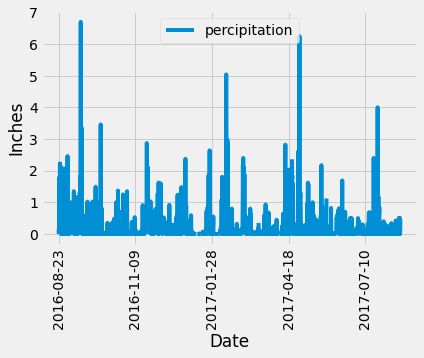

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
d = session.query(func.strftime('%Y-%m-%d', Measurement.date, '-1 years')).order_by(Measurement.date.desc()).all()
s = [items[0] for items in d]

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= s[0]).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column. Sort the dataframe by date
df = pd.DataFrame(data, columns= ["date", "prcp"]).set_index('date').sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["percipitation"])
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).distinct(Measurement.station).group_by(Measurement.station).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order. 
sel = [Measurement.station,
       func.count(Measurement.station)] 
       
q = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
q


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
stat = [item[0] for item in q]
count = [item[1] for item in q]
print(f"The most observed station is: {stat[0]} with {count[0]} observations.")


The most observed station is: USC00519281 with 2772 observations.


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low = session.query(Measurement.station, func.min(Measurement.tobs)).first()
high= session.query(Measurement.station, func.max(Measurement.tobs)).first()
avg = session.query(func.avg(Measurement.tobs)).first()
print(f"The station with the lowest temperature is {low[0]} at {low[1]} degrees.")
print(f"The station with the highest temperature is {high[0]} at {high[1]} degrees.")
print(f"The average temperature is {avg[0]} degrees.")


The station with the lowest temperature is USC00511918 at 53.0 degrees.
The station with the highest temperature is USC00519397 at 87.0 degrees.
The average temperature is 73.09795396419437 degrees.


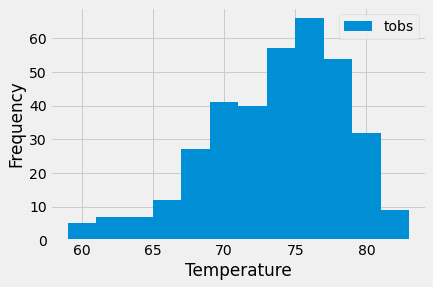

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.date).filter(Measurement.station == stat[0]).order_by(Measurement.date.desc()).first()

temp_data = session.query(Measurement.tobs).filter((Measurement.station == stat[0]) & (Measurement.date >= '2016-08-18')).all()
temp_data
# # Save the query results as a Pandas DataFrame and set the index to the date column. Sort the dataframe by date
df = pd.DataFrame(temp_data)

# # Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind = 'hist', bins=12)
plt.xlabel("Temperature")
plt.show()


## Bonus Challenge Assignment

### Part 1

In [19]:
#  Produce a dataframe from the provided csv

path = "Resources/hawaii_measurements.csv"
data = pd.read_csv(path)
data["date"]= pd.to_datetime(data["date"])
data



,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [20]:
#  Query for dates and temps in June
june = data.loc[data["date"].dt.month == 6,["date","tobs"]].set_index("date")
june

,tobs
date,
2010-06-01,78
2010-06-02,76
2010-06-03,78
2010-06-04,76
2010-06-05,77
...,...
2017-06-26,79
2017-06-27,74
2017-06-28,74


In [21]:
#  Query for dates and temps in Dec
dec = data.loc[data["date"].dt.month == 12,["date","tobs"]].set_index("date")
dec

,tobs
date,
2010-12-01,76
2010-12-03,74
2010-12-04,74
2010-12-06,64
2010-12-07,64
...,...
2016-12-27,71
2016-12-28,71
2016-12-29,69


In [22]:
# Perform t-test taken form https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/

from scipy.stats import t
from math import sqrt

def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = data1.mean(), data2.mean()
    # calculate standard errors
    se1, se2 = data1.sem(), data2.sem()
    # standard error on the difference between the samples
    sed = sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = float((mean1 - mean2) / sed)
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    print(f"t_stat: {t_stat}, df: {df}, cv: {cv}, p: {p}") 
    
    if t_stat < 0:
        t_stat *= -1
        
    if t_stat <= cv:
        print('Accept null hypothesis that the means are equal.')
    else:
        print('Reject the null hypothesis that the means are equal.')
    # interpret via p-value
    if p > alpha:
        print('Accept null hypothesis that the means are equal.')
    else:
        print('Reject the null hypothesis that the means are equal.')

In [23]:
# Run t-test.
independent_ttest(june, dec,.05)

t_stat: 31.355036920962426, df: 3215, cv: 1.6453277205705863, p: 0.0
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


There is a statistical difference in the data mean between June and December. This was derfived using the unpared t test because the two pieces of data are independent.

### Part 2

In [24]:


# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
start = '2012-05-06'
end = '2013-05-06'
print(calc_temps(start, end))

[(53.0, 72.23268274014542, 86.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2012-05-06'
end = '2013-05-06'
result = pd.DataFrame(calc_temps(start, end), columns = ["tmin","tavg", "tmax"])
result

,tmin,tavg,tmax
0,53.0,72.232683,86.0


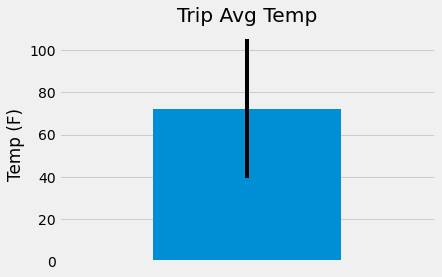

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = result['tmax'] - result['tmin']
tavg = result['tavg']
tavg.plot(kind = "bar",  yerr=error)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain = session.query(Measurement.station, func.sum(Measurement.prcp)).group_by(Measurement.station).order_by(Measurement.prcp.desc())\
        .filter(Measurement.date >= start).filter(Measurement.date <= end).all()
rain

[('USC00516128', 120.32999999999998),
 ('USC00514830', 18.099999999999994),
 ('USC00519523', 24.589999999999996),
 ('USC00519281', 49.91000000000002),
 ('USC00519397', 12.08),
 ('USC00513117', 30.34),
 ('USC00511918', 11.439999999999996),
 ('USC00518838', 3.8299999999999996),
 ('USC00517948', 3.8800000000000003)]

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start = '2012-05-06'
end = '2013-05-06'
# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= start).filter(Measurement.date <= end).all()
dates_str = [item[0] for item in dates]
# Stip off the year and save a list of %m-%d strings
clean_date = ['{:%m-%d}'.format(dt.datetime.strptime(x, '%Y-%m-%d')) for x in dates_str]
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in clean_date:
    result = daily_normals(date)
    normals.append(result)

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame([item[0] for item in normals], columns=["tmin","tavg","tmax"])
df["trip_dates"]= dates_str
short_df = df.set_index("trip_dates").head(7)
short_df

,tmin,tavg,tmax
trip_dates,,,
2012-05-06,66.0,73.140351,80.0
2012-05-07,64.0,71.788462,79.0
2012-05-08,65.0,72.188679,80.0
2012-05-09,67.0,72.932203,79.0
2012-05-10,64.0,73.315789,78.0
2012-05-11,65.0,73.611111,79.0
2012-05-12,65.0,73.137931,79.0


Text(0, 0.5, 'Temperature (F)')

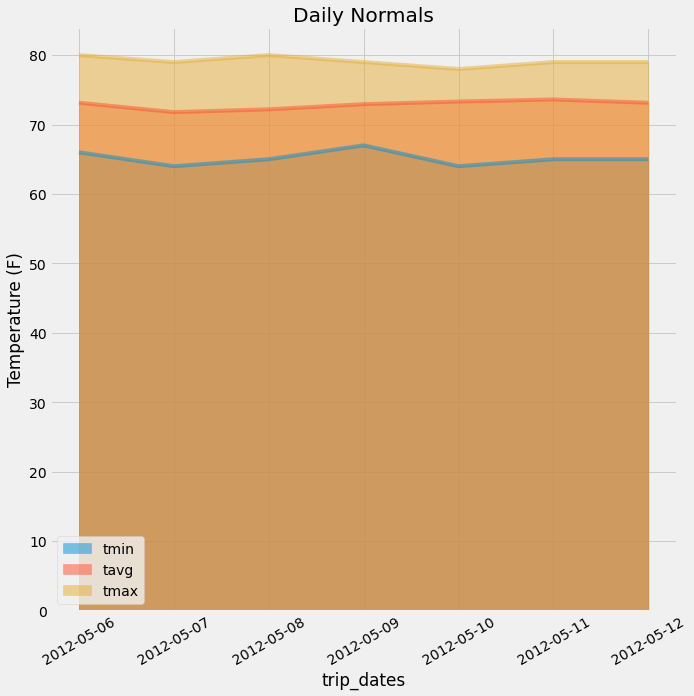

In [50]:
# Plot the daily normals as an area plot with `stacked=False`
short_df.plot(kind="area", stacked=False, rot=30, figsize=(10,10), title= "Daily Normals")
plt.ylabel("Temperature (F)")
